In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets
from astropy.cosmology import Planck13 as cosmo
import numpy as np
import sys
sys.path.append("..")
from src.mzr import am2013
from src.umachine_sfhs import relative_ia_rate
from src.umachine_sfhs import _MASSES_ as umachine_masses
load_mpl_presets()
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


In [22]:
path = "../src/data/umachine-dr1/data/sfhs"
masses = [7.3 + 0.2 * _ for _ in range(30)]
files = ["%s/sfh_sm%.2f_a1.002310.dat" % (path, mass) for mass in masses]
data = {}
for i in range(len(masses)):
    raw = np.genfromtxt(files[i])
    key = "%.2f" % (masses[i])
    data[key] = {}
    data[key]["scale_factor"] = [row[0] for row in raw]
    data[key]["sfh_all"] = [row[1] for row in raw]
    data[key]["sfh_all_+err"] = [row[2] for row in raw]
    data[key]["sfh_all_-err"] = [row[3] for row in raw]
# print(data["7.30"])

In [25]:
cosmo.lookback_time(2).value

10.511840978779919

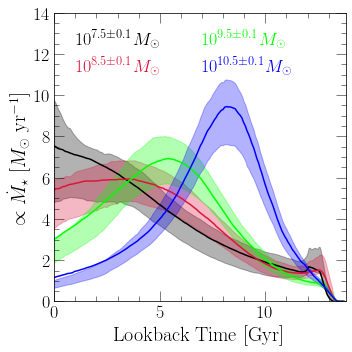

In [40]:
sm = [7.5, 8.5, 9.5, 10.5]
colors = {
    7.5: "black",
    8.5: "crimson",
    9.5: "lime",
    10.5: "blue"
}
multipliers = {
    7.5: 1000,
    8.5: 100,
    9.5: 10,
    10.5: 1
}

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Lookback Time [Gyr]")
ax.set_ylabel(r"$\propto\dot{M}_\star$ [$M_\odot$ yr$^{-1}$]")
ax.set_xlim([0, 13.8])
ax.set_ylim([0, 14])

for i in range(len(sm)):
    key = "%.2f" % (sm[i])
    z = [1 / _ - 1 for _ in data[key]["scale_factor"]]
    xvals = [cosmo.lookback_time(_).value for _ in z]
    yvals = [multipliers[sm[i]] * _ for _ in data[key]["sfh_all"]]
    kwargs = {
        "c": named_colors()[colors[sm[i]]],
        "label": r"$10^{%.1f \pm 0.1} M_\odot$" % (sm[i])
    }
    ax.plot(xvals, yvals, **kwargs)
    kwargs = {
        "color": named_colors()[colors[sm[i]]],
        "alpha": 0.3
    }
    yvals1 = [multipliers[sm[i]] * (a + b) for a, b in zip(data[key]["sfh_all"], data[key]["sfh_all_+err"])]
    yvals2 = [multipliers[sm[i]] * (a - b) for a, b in zip(data[key]["sfh_all"], data[key]["sfh_all_-err"])]
    ax.fill_between(xvals, yvals1, yvals2, **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "ncol": 2
}
leg = ax.legend(**kwargs)
fancy_legend(leg, [colors[_] for _ in sm])
    
plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./umachine_sfhs.%s" % (ext), **kwargs)
plt.show()

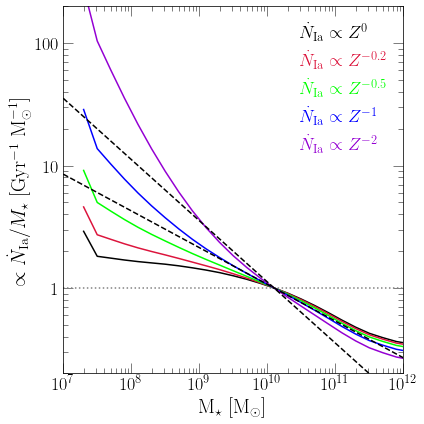

In [3]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"M$_\star$ [M$_\odot$]")
ax.set_ylabel(r"$\propto \dot{N}_\text{Ia} / M_\star$ [Gyr$^{-1}$ M$_\odot^{-1}$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlim([10**7, 10**12])
ax.set_ylim([0.2, 200])

# print(umachine_masses)

zscalings = [0, -0.2, -0.5, -1, -2]
colors = ["black", "crimson", "lime", "blue", "darkviolet"]
for i in range(len(zscalings)):
    xvals = [10**_ for _ in umachine_masses]
    yvals = []
    for j in range(len(xvals)):
        kwargs = {
            "Z": 0.014 * 10**am2013(xvals[j]),
            "Zscaling_plaw_index": zscalings[i]
        }
        yvals.append(relative_ia_rate(umachine_masses[j], **kwargs) / xvals[j])
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\dot{N}_\text{Ia} \propto Z^{%g}$" % (zscalings[i])
    }
    idx = umachine_masses.index(10.1)
    pre = 1 / yvals[idx]
    yvals = [pre * _ for _ in yvals]
    ax.plot(xvals, yvals, **kwargs)
    
kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0
}
leg = ax.legend(**kwargs)
fancy_legend(leg, colors)
    
ax.axhline(1, c = named_colors()["grey"], linestyle = ':')

xvals = np.logspace(7, 12, 1000)
yvals = [(_ / 10**10.1)**-0.5 for _ in xvals]
kwargs = {
    "c": named_colors()["black"],
    "linestyle": '--'
}
ax.plot(xvals, yvals, **kwargs)
yvals = [(_ / 10**10.1)**-0.3 for _ in xvals]
ax.plot(xvals, yvals, **kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("umachine_iarate_zscaling.%s" % (ext), **kwargs)
plt.show()